# Import

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

# bs = 100
# # MNIST Dataset
# train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
# test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# # Data Loader (Input Pipeline)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [9]:
for (data, _) in train_loader:
    print(data.shape)

NameError: name 'train_loader' is not defined

# VAE/Agent class

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.encoder_net = nn.Sequential( nn.Linear(x_dim, h_dim1),
                                 nn.LeakyReLU(),
                                 nn.Linear(h_dim1, h_dim2),
                                 nn.LeakyReLU())
#         self.fc1 = nn.Linear(x_dim, h_dim1)
#         self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        
        self.encoder_params = list(self.encoder_net.parameters()) + \
            list(self.fc31.parameters()) + \
            list(self.fc32.parameters())
        # decoder part
        
        self.decoder_net = nn.Sequential( nn.Linear(z_dim, h_dim2),
                                     nn.LeakyReLU(),
                                     nn.Linear(h_dim2, h_dim1),
                                     nn.LeakyReLU(), 
                                     nn.Linear(h_dim1, x_dim), 
                                     nn.Sigmoid())
        
        self.decoder_params = list(self.decoder_net.parameters())

            
#         self.fc4 = nn.Linear(z_dim, h_dim2)
#         self.fc5 = nn.Linear(h_dim2, h_dim1)
#         self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
#         h = F.relu(self.fc1(x))
#         h = F.relu(self.fc2(h))
        
        h = self.encoder_net(x)
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
#         h = F.relu(self.fc4(z))
#         h = F.relu(self.fc5(h))
        return self.decoder_net(z) # torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 25))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# # build model
# vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
# if torch.cuda.is_available():
#     vae.cuda()

In [21]:
class agent():
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        self.vae = VAE(x_dim=x_dim, h_dim1= h_dim1, h_dim2=h_dim2, z_dim=z_dim)
        if torch.cuda.is_available():
            self.device = "cuda"
            self.vae.cuda()
        else:
            self.device = "cpu"
        self.z_dim = z_dim
        
        # optimizers
        self.optimizer_speaker = optim.Adam(self.vae.decoder_params)  # speaker is trying to make unique signals which only uses 
        self.optimizer_listen = optim.Adam(self.vae.parameters())
        
    
    def generate_signal(self):
        mu = torch.normal(0., 1., size=(self.z_dim,)).to(self.device)
        log_var = torch.normal(0., 1., size=(self.z_dim,)).to(self.device)
        
        z = self.vae.sampling(mu, log_var)
        signal = self.vae.decoder(z)
        return signal
    

# return reconstruction error + KL divergence losses
def listener_loss_function(recon_x, x, mu, log_var):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    MSE = F.mse_loss(recon_x, x.view(-1, 25), reduction='sum')  # loss that tries to copy/reconstruct speaker's message
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + KLD

def speaker_loss_function(recon_x, x, mu, log_var):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
#     MSE = (2 - torch.abs(F.mse_loss(recon_x, x.view(-1, 25), reduction='sum')) )  # loss that tries to keep speaker's message unique
    MSE = torch.sum(torch.pow(2 - torch.abs(recon_x - x), 2))
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + KLD

# populate agents
numAgents = 10

agents = []
for i in range(0, numAgents):
    agents.append(agent(x_dim=25, h_dim1 = 400, h_dim2=400, z_dim=10))

# Optimizer/Training

In [ ]:
def train_interact(epoch):
    vae.train()
    train_loss = 0
    
    for iT in range(0, 1000):
        
        
        data = 
        
        recon_batch, mu, log_var = vae(data)
    
    
    
    
    
    
    
    
    for batch_idx, (data, _) in enumerate(train_loader):
        
        data = 
#         data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [31]:
numMsgs = 10

def train(epoch):
    
    for agent in agents:
        agent.vae.train()
    
    train_speaker_loss = 0
    train_listener_loss = 0
    
    speak_count = 0
        
    speaker_order = np.random.permutation(np.arange(0, len(agents)))
    for i in speaker_order:
        listener = agents[i]
        neighbours = [(i - 1) % len(agents), (i + 1) % len(agents)]  # periodic chain
        
        # data = [agents[n].generate_signal() for i in range(numMsgs) for n in neighbours]
        
        listener.optimizer_listen.zero_grad()
        
        for n in neighbours:
            speaker = agents[n]
            speaker.optimizer_speaker.zero_grad()
            
            data = [speaker.generate_signal() + 0.05*torch.randn(25).cuda() for i in range(numMsgs)]
            t_data = data[0].view(1, -1)
            for item in data[1:]:
                t_data=torch.cat((t_data,item.view(1, -1)),dim=0)
            data = t_data

            recon_batch, mu, log_var = listener.vae(data)
            listener_loss = listener_loss_function(recon_batch, data, mu, log_var)
            speaker_loss = speaker_loss_function(recon_batch, data, mu, log_var)
            
            speaker_loss.backward(retain_graph=True)
            listener_loss.backward(retain_graph=True)
            
            train_speaker_loss += speaker_loss.item()
            speaker.optimizer_speaker.step()
            speak_count += 1

        train_listener_loss += listener_loss.item()
        listener.optimizer_listen.step()
        
    train_speaker_loss = train_speaker_loss / speak_count
    train_listener_loss = train_listener_loss / len(agents)
    
    print(f'====> Epoch: {epoch} Speak/Listen loss: {train_speaker_loss:.4f}/{train_listener_loss:.4f} ')
    
    return train_speaker_loss, train_listener_loss

In [ ]:
# loss = []
for epoch in range(1, 500):
    loss.append(train(epoch))
#     test()

s_loss = [l[0] for l in loss]
l_loss = [l[1] for l in loss]

plt.plot(s_loss, label='speaker')
plt.plot(l_loss, label='listener')
plt.legend()

====> Epoch: 1 Speak/Listen loss: 382.1810/186.4475 
====> Epoch: 2 Speak/Listen loss: 382.3591/186.4566 
====> Epoch: 3 Speak/Listen loss: 387.7291/188.0479 
====> Epoch: 4 Speak/Listen loss: 391.3000/186.4921 
====> Epoch: 5 Speak/Listen loss: 377.4682/195.0569 
====> Epoch: 6 Speak/Listen loss: 382.8874/188.6404 
====> Epoch: 7 Speak/Listen loss: 383.9867/188.6313 
====> Epoch: 8 Speak/Listen loss: 388.4261/189.2246 
====> Epoch: 9 Speak/Listen loss: 392.9895/183.1204 
====> Epoch: 10 Speak/Listen loss: 382.1288/186.3368 
====> Epoch: 11 Speak/Listen loss: 385.8476/186.5646 
====> Epoch: 12 Speak/Listen loss: 381.0145/184.3099 
====> Epoch: 13 Speak/Listen loss: 387.3432/183.0094 
====> Epoch: 14 Speak/Listen loss: 383.5252/191.1736 
====> Epoch: 15 Speak/Listen loss: 381.0561/184.8215 
====> Epoch: 16 Speak/Listen loss: 386.5373/182.8181 
====> Epoch: 17 Speak/Listen loss: 380.5782/187.4638 
====> Epoch: 18 Speak/Listen loss: 381.1848/189.4436 
====> Epoch: 19 Speak/Listen loss: 37

# Visualize

## Generate images for each agent

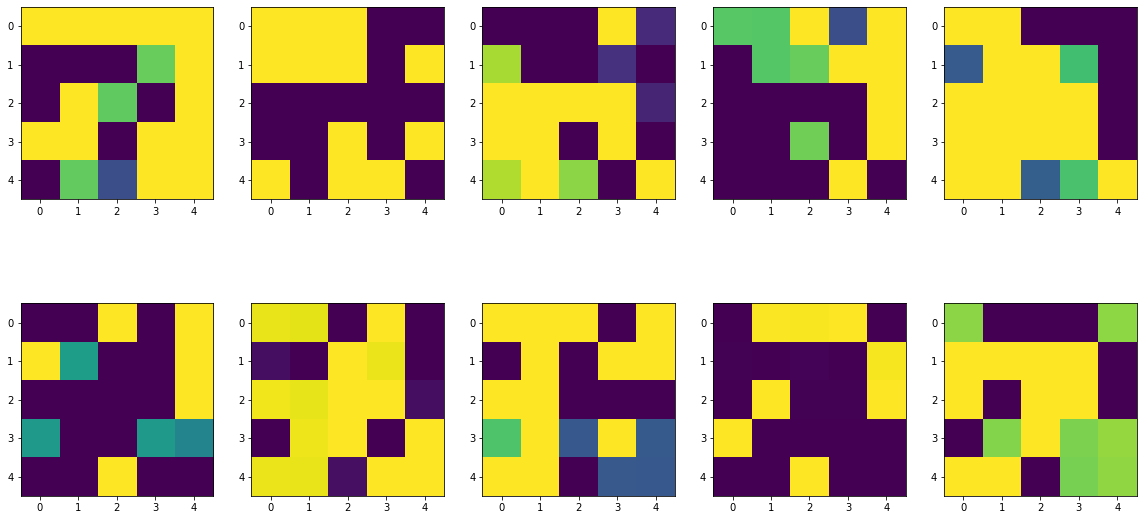

In [33]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(agents[i].generate_signal().cpu().detach().reshape(5,5))

In [ ]:
## Generate images for one agents

## Generate images for one agents

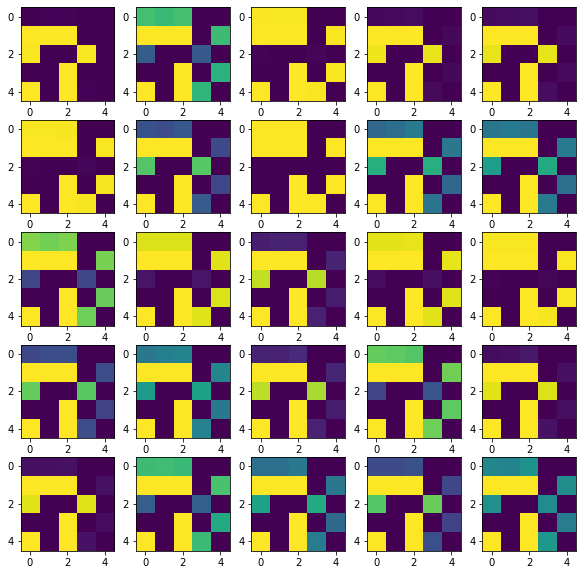

In [34]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

i = 1
for ax in axs.flatten():
    ax.imshow(agents[i].generate_signal().cpu().detach().reshape(5,5))

## Encode an image (or noise)

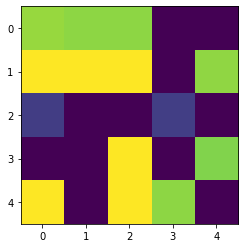

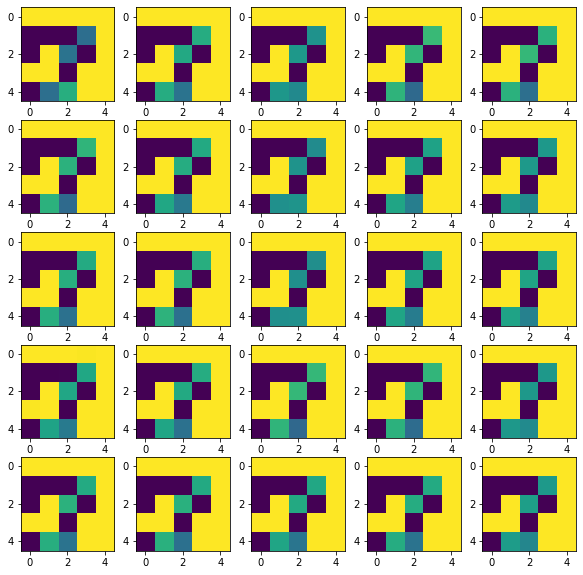

In [35]:
i = 1  # speaker
j = 0  # listener

# image to reconstruct
signal_i = agents[i].generate_signal()
img_i = signal_i.cpu().detach().reshape(5,5)

# random image
# signal_i = torch.randn(25).cuda()
# img_i = signal_i.cpu().detach().reshape(5,5)


plt.imshow(img_i)


fig, axs = plt.subplots(5, 5, figsize=(10, 10))
# reconstruction
for ax in axs.flatten():
    ax.imshow(agents[j].vae(signal_i)[0].cpu().detach().reshape(5,5))
    
    

In [41]:
# Debug

In [222]:
data = [agents[0].generate_signal() for i in range(numMsgs)]
t_data = data[0].view(1, -1)
for item in data[1:]:
    t_data=torch.cat((t_data,item.view(1, -1)),dim=0)
    
t_data

tensor([[0.4844, 0.5276, 0.5003, 0.5722, 0.4717, 0.5699, 0.5534, 0.4541, 0.5044,
         0.5125, 0.4875, 0.4442, 0.5457, 0.5306, 0.5260, 0.5084, 0.4900, 0.5720,
         0.4873, 0.4732, 0.4692, 0.4590, 0.5524, 0.5184, 0.5062],
        [0.4991, 0.5503, 0.4910, 0.5422, 0.4915, 0.5699, 0.5457, 0.4782, 0.4902,
         0.4741, 0.4732, 0.4520, 0.5871, 0.5808, 0.5663, 0.5106, 0.4256, 0.5946,
         0.4597, 0.4905, 0.4740, 0.4573, 0.5626, 0.4989, 0.5314],
        [0.4902, 0.5437, 0.5393, 0.5342, 0.4384, 0.5387, 0.5885, 0.5264, 0.5231,
         0.4640, 0.5521, 0.4300, 0.5718, 0.5262, 0.4920, 0.4693, 0.4806, 0.5740,
         0.4946, 0.4066, 0.4744, 0.4936, 0.5163, 0.4434, 0.5232],
        [0.4958, 0.5399, 0.5282, 0.5330, 0.4448, 0.5562, 0.5688, 0.5212, 0.5050,
         0.4710, 0.5216, 0.4466, 0.5572, 0.5224, 0.5178, 0.5204, 0.4718, 0.5811,
         0.4813, 0.4289, 0.4834, 0.5101, 0.5117, 0.4910, 0.5282],
        [0.4665, 0.5225, 0.4955, 0.5657, 0.4623, 0.5670, 0.5358, 0.4308, 0.4952,
       